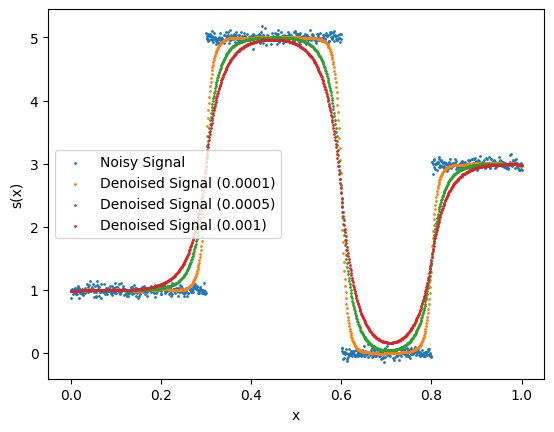

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt
f = pd.read_csv("noisy_signal.csv", header=None)[0].values
n = len(f)
L = np.eye(n) - np.eye(n, k = 1)
L = L[:-1,:] * n
solution = {}
for omega in [1e-4, 5e-4, 1e-3]:
    solution[omega] = solve(np.eye(n) + omega * (L.T @ L), f)
x = np.linspace(0, 1, n)
plt.figure()
plt.scatter(x, f, label = "Noisy Signal", s = 1)
for omega, sol in solution.items():
    plt.scatter(x, sol, label = f"Denoised Signal ({omega})", s = 1)
plt.xlabel("x")
plt.ylabel("s(x)")
plt.legend()
plt.show()

1164 1.3498361110687256


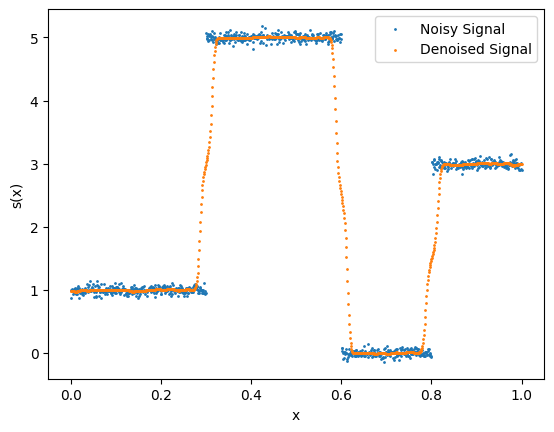

In [2]:
import scipy.sparse as sp
import time
n = 999
lamda = 5e-4
gamma = 1e3
omega = 75
alpha = 0.5
beta = 0.5
data = np.array([np.ones(n) * n, -np.ones(n) * n])
L = sp.diags(data, [0, 1], shape = (n, n + 1))
A_bar = sp.hstack((sp.eye(n + 1), sp.csr_matrix((n + 1, n))))
L_bar = sp.hstack((-L, sp.eye(n)))
omega_bar = np.concatenate([np.zeros(n + 1), omega * np.ones(n)])
x = f.copy()
y = np.zeros(n)
z = np.ones(n)
def h_gamma(t):
    return np.where(np.abs(t) <= 1 / gamma, 0.5 * gamma * t ** 2,
                    np.abs(t) - 1 / (2 * gamma))
def h_gamma_prime(t):
    return np.where(np.abs(t) <= 1 / gamma, gamma * t, np.sign(t))
def J(u, z):
    J1 = 0.5 * np.linalg.norm(A_bar @ u - f) ** 2
    J2 = 0.5 * lamda * np.linalg.norm(L_bar @ u - z) ** 2
    return J1 + J2 + np.dot(omega_bar, h_gamma(u))
def J_grad(u, z):
    J1_grad = A_bar.T @ (A_bar @ u - f)
    J2_grad = lamda * (L_bar.T @ (L_bar @ u - z))
    return J1_grad + J2_grad + omega_bar * h_gamma_prime(u)
outer_tolerance = 1e-5
inner_tolerance = 1e-4
iteration = 0
start_time = time.time()
while True:
    u = np.concatenate([x, y])
    for k in range(500):
        d = -J_grad(u, z)
        t = 1e-2
        while J(u, z) - J(u + t * d, z) < -alpha * t * np.dot(J_grad(u, z), d):
            t = t * beta
        u_new = u + d * t
        if np.linalg.norm(u_new - u) / np.linalg.norm(u_new) < inner_tolerance:
            iteration += k + 1
            break
        u = u_new
    x_new = u[:n + 1]
    y_new = u[n + 1:]
    z += L @ x_new - y_new
    if np.linalg.norm(x_new - x) / np.linalg.norm(x_new) < outer_tolerance:
        break
    x = x_new
    y = y_new
print(iteration, time.time() - start_time)
xx = np.linspace(0, 1, n + 1)
plt.figure()
plt.scatter(xx, f, label = 'Noisy Signal', s = 1)
plt.scatter(xx, x, label = 'Denoised Signal', s = 1)
plt.legend()
plt.xlabel('x')
plt.ylabel('s(x)')
plt.show()

29 1.3256916999816895


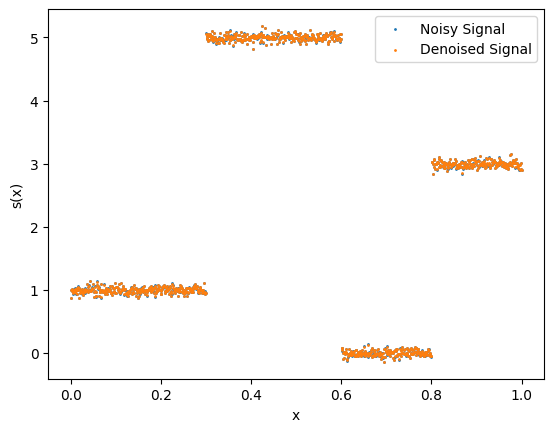

In [3]:
lamda = 1e-2
omega = 2e-3
x = f.copy()
L = np.eye(n + 1, k = 0) - np.eye(n + 1, k = 1)
y = np.dot(L, x)
z = np.ones(n + 1)
def S(t, eta):
    return np.sign(t) * np.maximum(np.abs(t) - eta, 0)
def solve(y, z, f, lamda, L):
    A = np.eye(n + 1) + lamda * np.dot(L.T, L)
    b = f + lamda * np.dot(L.T, y - z)
    return np.linalg.solve(A, b)
iteration = 0
start_time = time.time()
while True:
    x_new = solve(y, z, f, lamda, L) 
    y_new = S(np.dot(L, x_new) + z, omega / lamda)
    z += np.dot(L, x_new) - y_new
    if np.linalg.norm(x_new - x) / np.linalg.norm(x_new) < outer_tolerance:
        break
    x = x_new
    y = y_new
    iteration += 1
print(iteration, time.time() - start_time)
xx = np.linspace(0, 1, n + 1)
plt.figure()
plt.scatter(xx, f, label = 'Noisy Signal', s = 1)
plt.scatter(xx, x, label = 'Denoised Signal', s = 1)
plt.legend()
plt.xlabel('x')
plt.ylabel('s(x)')
plt.show()